**6820017_ArimitraMaiti_IA2**

### <center>Tripadvisor Review Brand Performance Analysis in Jupyter (Part-II)</center>
<center>Big Data Analytics - Analysis of Text and Social Media Data: Individual Assignment Week-4</center>
<center>ePGD ABA 2020-21</center>

**Second notebook for data analysis and model building**

**CAUTION - This notebook takes roughly 25 minutes to complete execution (excluding model train) \
This notebook may not run end to end in google colab environment or mac environment \
The input file for this notebook comes from the output of the first notebook**

In [1]:
###Need to use nltk download commands for the first time to set up the machine
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('sentiwordnet')

In [2]:
##Import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import sys

In [3]:
import string
import re

In [4]:
# !pip install wordcloud
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
# conda config --add channels conda-forge
# conda install pyahocorasick
# !pip install contractions
import contractions

In [7]:
from nltk.corpus import wordnet

In [8]:
# !pip install textblob
from textblob import TextBlob

In [9]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

In [10]:
# !pip install afinn
from afinn import Afinn

In [11]:
# ##Import review data obtained from tripadvisor crawler
# dataset = pd.read_csv("reviews_brandperformance.csv", parse_dates=True, usecols=['score', 'date', 'title', 'review',
#                                                                               'link_id', 'Name', 'Location', 'City'])
# dataset.head()

In [12]:
##Import review data obtained from tripadvisor crawler
url = "https://raw.githubusercontent.com/arimitramaiti/datasets/master/articles/reviews_brandperformance.csv"
dataset = pd.read_csv(url, error_bad_lines = False, header=0, index_col=None, parse_dates=True, 
                      usecols=['score', 'date', 'title', 'review','link_id', 'Name', 'Location', 'City'])
dataset.head(4)

,score,date,title,review,link_id,Name,Location,City
0,40,8-Mar-20,Good food,"Good food , nice service. No wow factor. Could...",https://www.tripadvisor.in/Restaurant_Review-g...,China Bistro,Worli,Mumbai
1,40,28-Feb-20,"Good food, great service!","As always, the food was well prepared and flav...",https://www.tripadvisor.in/Restaurant_Review-g...,China Bistro,Worli,Mumbai
2,40,4-Feb-20,"Excellant food, served with enthusiasm","Yes, the food was wonderful. Regular stuff, al...",https://www.tripadvisor.in/Restaurant_Review-g...,China Bistro,Worli,Mumbai
3,50,3-Feb-20,Khowsuey,The khowsuey is amazing out here. Absolute val...,https://www.tripadvisor.in/Restaurant_Review-g...,China Bistro,Worli,Mumbai


In [13]:
##Sort data by date of review
dataset = dataset.sort_values(by=['date'], ascending=False)

In [14]:
##Reset index
dataset = dataset.reset_index(drop="index")

In [15]:
dataset.head()

,score,date,title,review,link_id,Name,Location,City
0,30,9-Sep-15,Nice ambience but so-so food,The décor is nice and the staff is friendly. S...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai
1,40,9-Sep-15,Pooja maheshwari,If you want Chinese cuisine experience without...,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai
2,30,9-Sep-12,MC is one of the best place for Authentic Chin...,I have been a regular to Mainland China since ...,https://www.tripadvisor.in/Restaurant_Review-g...,Asia Kitchen,City Point,Pune
3,50,9-Oct-19,Great choice of indo-chinese dishes,"From Lamb Racks to prawns, every preparation a...",https://www.tripadvisor.in/Restaurant_Review-g...,Asia Kitchen,Andheri,Mumbai
4,40,9-Oct-19,Great Chinese,Simply outstanding food. The highlight is the ...,https://www.tripadvisor.in/Restaurant_Review-g...,All Stir Fry,Colaba,Mumbai


In [16]:
##Check for missing values in the dataset
dataset.isnull().sum()/dataset.shape[0] * 100

score       0.0
date        0.0
title       0.0
review      0.0
link_id     0.0
Name        0.0
Location    0.0
City        0.0
dtype: float64

In [17]:
##Map bubble rating score to 3 classes, 1 having score 10 & 20, 2 having score 30, 3 having score of 40 & 50 
score_mapping = {10:0, 20:0, 30:1, 40:2, 50:2}
dataset["target"] = dataset.score.map(score_mapping)

In [18]:
dataset.target.value_counts().sort_index()

0     151
1     358
2    2199
Name: target, dtype: int64

In [19]:
dataset.score.value_counts().sort_index()

10      53
20      98
30     358
40    1293
50     906
Name: score, dtype: int64

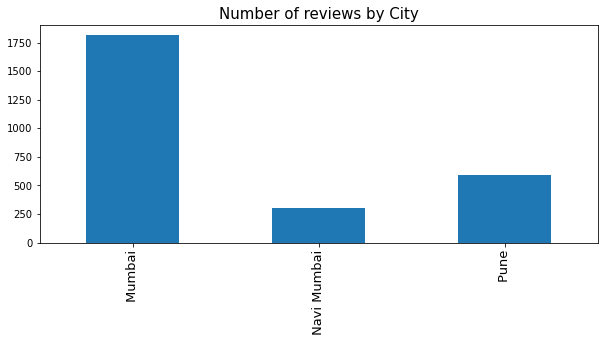

In [20]:
##Number of reviews collected per city
dataset['City'].value_counts().sort_index().plot(kind='bar', figsize=(10,4));
plt.title('Number of reviews by City', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

In [21]:
dataset['Name'].unique()

array(['Mainland China', 'Asia Kitchen', 'All Stir Fry', 'Mamagoto',
       'China Bistro'], dtype=object)

In [22]:
my_stop_list_ = ['bistro', 'china', 'chinese', 'food', 'dish', 'dishes', 'foodie', 'dine', 'dining', 'one', 'ok', 'okay',
                      'asia', 'kitchen', 'stir', 'mamagoto', 'mainland', 'china', ]

In [23]:
dataset_processing = dataset.copy()

In [24]:
dataset_processing.shape

(2708, 9)

In [25]:
import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import sentiwordnet as swn

In [26]:
def pre_processing(dataset, my_stop_list):
    ##Use contractions
    dataset['review_modified'] = dataset['review'].apply(lambda x: [contractions.fix(word) for word in x.split()])
    ##convert list to string
    dataset['review_modified_unlist'] = [' '.join(map(str, l)) for l in dataset['review_modified']]
    ##convert string to tokens
    dataset['review_mod_tokens'] = dataset['review_modified_unlist'].apply(nltk.word_tokenize)
    ##convert token to lower case
    dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word.lower() for word in x])
    ##remove punctuations
    dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word for word in x if word not in string.punctuation])
    stop_set = set(nltk.corpus.stopwords.words('english'))
    stop_set.update(my_stop_list)
    ##remove default and custom stop words
    dataset['review_mod_tokens'] = dataset['review_mod_tokens'].apply(lambda x: [word for word in x if word not in stop_set])
    ##extract parts of speech tags
    dataset['review_tags'] = dataset['review_mod_tokens'].apply(nltk.tag.pos_tag)
    
    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    dataset['review_wordnet'] = dataset['review_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    ##use lemmatizer on parts of speech tags
    lm = WordNetLemmatizer()
    dataset['review_lemmatized'] = dataset['review_wordnet'].apply(lambda x: [lm.lemmatize(word, tag) for word, tag in x])
    
    dataset['review_str'] = [' '.join(map(str,l)) for l in dataset['review_lemmatized']]
    ##extract sentiment score from parts of speech tags
    dataset['sentiment_score_textblob'] = dataset['review_str'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    def afinn_polarity(text):
        return Afinn().score(text)
    
    def score_sentiwordnet(doc):
        synsets = (wordnet.synsets(w) for w in nltk.word_tokenize(doc) if w is not None) # tokenize and lookup synonyms in WordNet
        words = (s[0].name() for s in synsets if s is not None and len(s) > 0) # use the first (most common) synonym
        words = (swn.senti_synset(s) for s in words) # get sentiment scores which have pos, neg, and neutral parts
        scores = ((1 - w.obj_score()) * (w.pos_score() - w.neg_score()) for w in words) # calculate individual word scores
        return (sum(scores) > 0) # classify document as positive if resulting score is positive
    
    def ifformula(score):
        if score < 0:
            return False
        else:
            return True
    
    dataset['sentiment_score_afinn'] = dataset['review_str'].apply(afinn_polarity)
    dataset['sentiment_score_sentinet'] = dataset['review_str'].apply(score_sentiwordnet)
    dataset['sentiment_score_afinn'] = dataset['sentiment_score_afinn'].apply(ifformula)
    dataset['sentiment_score_textblob'] = dataset['sentiment_score_textblob'].apply(ifformula)
    
    dataset = dataset[['score', 'date', 'title', 'link_id', 'Name', 'Location', 'City', 'target', 'review_lemmatized',
                       'review_str', 'sentiment_score_textblob', 'sentiment_score_sentinet', 'sentiment_score_afinn']]

    return dataset

In [27]:
dataset_processing = pre_processing(dataset_processing, my_stop_list_)

In [28]:
dataset_processing.head(3)

,score,date,title,link_id,Name,Location,City,target,review_lemmatized,review_str,sentiment_score_textblob,sentiment_score_sentinet,sentiment_score_afinn
0,30,9-Sep-15,Nice ambience but so-so food,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai,1,"[décor, nice, staff, friendly, item, menu, usu...",décor nice staff friendly item menu usual run ...,True,True,True
1,40,9-Sep-15,Pooja maheshwari,https://www.tripadvisor.in/Restaurant_Review-g...,Mainland China,Andheri,Mumbai,2,"[want, cuisine, experience, without, visit, pl...",want cuisine experience without visit place be...,True,True,True
2,30,9-Sep-12,MC is one of the best place for Authentic Chin...,https://www.tripadvisor.in/Restaurant_Review-g...,Asia Kitchen,City Point,Pune,1,"[regular, since, 2004, visit, chain, chennai, ...",regular since 2004 visit chain chennai hyderab...,True,True,True


In [29]:
dataset_processing['word_count'] = dataset_processing['review_lemmatized'].apply(lambda x: len(str(x).split()))
dataset_processing['review_length'] = dataset_processing['review_str'].astype(str).apply(len)

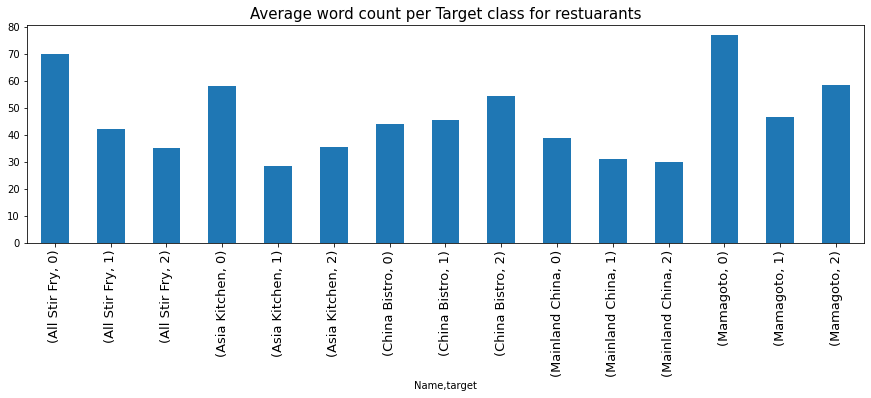

In [30]:
##Average word count for each target class
dataset_processing.groupby(['Name', 'target'])['word_count'].mean().plot(kind='bar', figsize=(15,4));
plt.title('Average word count per Target class for restuarants', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

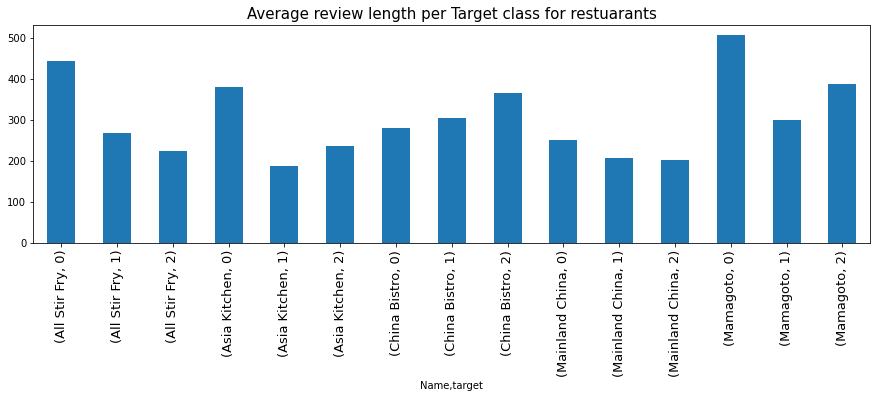

In [31]:
##Average length of comments for each target class
dataset_processing.groupby(['Name', 'target'])['review_length'].mean().plot(kind='bar', figsize=(15,4));
plt.title('Average review length per Target class for restuarants', fontsize=15)
plt.xticks(fontsize=13)
plt.show()

In [32]:
##Process to extract LDA topics
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(dataset_processing['review_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))

lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0:
good taste place authentic like really dim sum variety also
Topic 1:
outlet visit pune restaurant mumbai andheri chain best mall city
Topic 2:
place love great must try visit really awesome go birthday
Topic 3:
chicken rice soup noodle fry main good order starter crispy
Topic 4:
buffet veg lunch starter main good non course money dessert
Topic 5:
good service place staff restaurant excellent ambience great nice visit
Topic 6:
wok place sauce go choose fry carte like make option
Topic 7:
good service time place go restaurant well price quality get
Topic 8:
sauce chicken thai ice rice cream dumpling curry fish serve
Topic 9:
order would go restaurant come table get take time say


In [33]:
lda_topic_values = lda_model.transform(tf)
dataset_processing['lda_topic_id'] = lda_topic_values.argmax(axis=1)

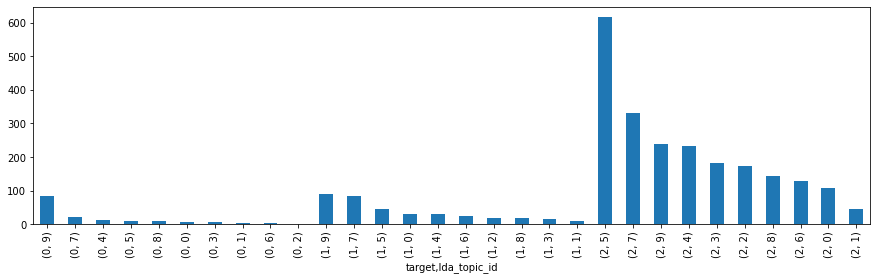

In [34]:
##Plot LDA topics to each row of the dataset and check distribution for each target class
dataset_processing.groupby('target')['lda_topic_id'].value_counts().plot(kind='bar', figsize=(15,4));

In [35]:
dataset_processing.columns

Index(['score', 'date', 'title', 'link_id', 'Name', 'Location', 'City',
       'target', 'review_lemmatized', 'review_str', 'sentiment_score_textblob',
       'sentiment_score_sentinet', 'sentiment_score_afinn', 'word_count',
       'review_length', 'lda_topic_id'],
      dtype='object')

In [36]:
dataset_processing['index'] = dataset_processing.index

In [37]:
f1 = ['ambiance', 'decor', 'environment', 'ambience']
pattern_f1 = '|'.join(f1)

dataset_processing['f1'] = np.where(dataset_processing['index'].isin(list(dataset_processing[dataset_processing['review_str'].str.contains(pattern_f1)].index)),
                                'yes','no')

In [38]:
f2 = ['starter']
pattern_f2 = '|'.join(f2)

dataset_processing['f2'] = np.where(dataset_processing['index'].isin(list(dataset_processing[dataset_processing['review_str'].str.contains(pattern_f2)].index)),
                                'yes','no')

In [39]:
f3 = ['staff', 'service', 'services']
pattern_f3 = '|'.join(f3)

dataset_processing['f3'] = np.where(dataset_processing['index'].isin(list(dataset_processing[dataset_processing['review_str'].str.contains(pattern_f3)].index)),
                                'yes','no')

In [40]:
f4 = ['buffet']
pattern_f4 = '|'.join(f4)

dataset_processing['f4'] = np.where(dataset_processing['index'].isin(list(dataset_processing[dataset_processing['review_str'].str.contains(pattern_f4)].index)),
                                'yes','no')

In [41]:
f5 = ['price', 'money']
pattern_f5 = '|'.join(f5)

dataset_processing['f5'] = np.where(dataset_processing['index'].isin(list(dataset_processing[dataset_processing['review_str'].str.contains(pattern_f5)].index)),
                                'yes','no')

In [42]:
f6 = ['taste', 'tasty']
pattern_f6 = '|'.join(f6)

dataset_processing['f6'] = np.where(dataset_processing['index'].isin(list(dataset_processing[dataset_processing['review_str'].str.contains(pattern_f6)].index)),
                                'yes','no')

In [43]:
f7 = ['location']
pattern_f7 = '|'.join(f7)

dataset_processing['f7'] = np.where(dataset_processing['index'].isin(list(dataset_processing[dataset_processing['review_str'].str.contains(pattern_f7)].index)),
                                'yes','no')

In [44]:
dataset_processing['yes_count'] = dataset_processing.loc[:, 'f1':'f7'].apply(lambda x: x.str.lower().str.findall('yes').str.len()).sum(axis=1).astype(int)

In [45]:
df_rca = dataset_processing.loc[(dataset_processing.yes_count>1) & (dataset_processing.sentiment_score_sentinet==False), :]

In [46]:
df_rca.shape

(134, 25)

In [47]:
a1 = pd.DataFrame({'search_tokens':f1})
a1['factor'] = "f1"
a2 = pd.DataFrame({'search_tokens':f2})
a2['factor'] = "f2"
a3 = pd.DataFrame({'search_tokens':f3})
a3['factor'] = "f3"
a4 = pd.DataFrame({'search_tokens':f4})
a4['factor'] = "f4"
a5 = pd.DataFrame({'search_tokens':f5})
a5['factor'] = "f5"
a6 = pd.DataFrame({'search_tokens':f6})
a6['factor'] = "f6"
a7 = pd.DataFrame({'search_tokens':f7})
a7['factor'] = "f7"

search_df = pd.concat([a1,a2,a3,a4,a5,a6,a7], axis=0)

search_df.reset_index(inplace=True, drop=True)

del a1,a2,a3,a4,a5,a6,a7

In [48]:
from sklearn.neighbors import NearestNeighbors

In [49]:
def score_sentiwordnet(doc):
    synsets = (wordnet.synsets(w) for w in nltk.word_tokenize(doc) if w is not None) # tokenize and lookup synonyms in WordNet
    words = (s[0].name() for s in synsets if s is not None and len(s) > 0) # use the first (most common) synonym
    words = (swn.senti_synset(s) for s in words) # get sentiment scores which have pos, neg, and neutral parts
    scores = ((1 - w.obj_score()) * (w.pos_score() - w.neg_score()) for w in words) # calculate individual word scores
    return (sum(scores)>0) # classify document as positive if resulting score is positive

def afinn_polarity(text):
    return Afinn().score(text)>=0

In [50]:
store = []
for i in range(df_rca.shape[0]):
    x = list(df_rca.iloc[i, 8])
    bigrams_list = list(nltk.bigrams(df_rca.iloc[i, 8]))
    dictionary2 = [' '.join(tup) for tup in bigrams_list] 
   
    for j in range(search_df.shape[0]):
        pick_token = search_df['search_tokens'][j]
        if len([s for s in dictionary2 if pick_token in s])>0:
            mylst = [s for s in dictionary2 if pick_token in s]
            m1 = score_sentiwordnet(' '.join(mylst))
            m2 = afinn_polarity(' '.join(mylst))
            if (m1==False and m2==False):
                m3='yes'
            else:
                m3 = 'no'
            x1 = search_df['search_tokens'][j]
            x2 = search_df['factor'][j]
            x3 = m3
            x4 = i
            collect = [x1, x2, x3, x4]
            store.append(collect)

In [51]:
collect_df = pd.DataFrame(store, columns=['search_tokens', 'factor', 'correction', 'df_rca_row'])

In [52]:
del store

In [53]:
result = collect_df.pivot_table(index='df_rca_row', columns='factor', values='correction', aggfunc='first')
result.columns.name = None
result = result.reset_index().rename_axis(None, axis=1)
result['source_index'] = df_rca.index

result.fillna("no", inplace=True)

result.set_index('source_index', inplace=True, drop=True)

result.drop(labels=['df_rca_row'], inplace=True, axis=1)

result.columns = ["f1_corr", "f2_corr", "f3_corr", "f4_corr", "f5_corr", "f6_corr", "f7_corr"]

In [54]:
df_rem = dataset_processing.loc[(dataset_processing.yes_count<=1) & (dataset_processing.sentiment_score_sentinet==False), :]

In [55]:
df_rem.shape

(204, 25)

In [56]:
result_new = pd.merge(result, df_rca, how="left", left_index=True, right_index=True)

In [57]:
result_new.columns

Index(['f1_corr', 'f2_corr', 'f3_corr', 'f4_corr', 'f5_corr', 'f6_corr',
       'f7_corr', 'score', 'date', 'title', 'link_id', 'Name', 'Location',
       'City', 'target', 'review_lemmatized', 'review_str',
       'sentiment_score_textblob', 'sentiment_score_sentinet',
       'sentiment_score_afinn', 'word_count', 'review_length', 'lda_topic_id',
       'index', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'yes_count'],
      dtype='object')

In [58]:
df_corrected = result_new[['Name', 'Location', 'City', 'target', 'date',
                           'review_lemmatized', 'review_str',
                          'f1_corr', 'f2_corr', 'f3_corr', 'f4_corr', 'f5_corr', 'f6_corr', 'f7_corr',
                          'sentiment_score_sentinet', 'sentiment_score_afinn', 'yes_count', 'lda_topic_id']]

In [59]:
df_corrected.columns = ['Name', 'Location', 'City', 'target', 'date',
                           'review_lemmatized', 'review_str',
                          'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7',
                          'sentiment_score_sentinet', 'sentiment_score_afinn', 'yes_count', 'lda_topic_id']

In [60]:
df_corrected.shape

(134, 18)

In [61]:
df_rem = df_rem[['Name', 'Location', 'City', 'target', 'date',
                           'review_lemmatized', 'review_str',
                          'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7',
                          'sentiment_score_sentinet', 'sentiment_score_afinn', 'yes_count', 'lda_topic_id']]

In [62]:
df_sentiwordnet = pd.concat([df_rem, df_corrected], axis=0)

In [63]:
df_sentiwordnet.shape

(338, 18)

In [64]:
df_sentiwordnet.reset_index(inplace=True, drop=True)

In [65]:
del df_rem, df_corrected

In [66]:
df_sentiwordnet.Name.value_counts()

Mainland China    189
Asia Kitchen       58
All Stir Fry       41
Mamagoto           35
China Bistro       15
Name: Name, dtype: int64

In [67]:
df_sentiwordnet['Entity'] = 'Unknown'
df_sentiwordnet.loc[df_sentiwordnet['Name']=='Mamagoto', 'Entity'] = 'External'
df_sentiwordnet.loc[df_sentiwordnet['Name']=='China Bistro', 'Entity'] = 'External'
df_sentiwordnet.loc[df_sentiwordnet['Name']=='All Stir Fry', 'Entity'] = 'External'
df_sentiwordnet.loc[df_sentiwordnet['Name']=='Asia Kitchen', 'Entity'] = 'Internal'
df_sentiwordnet.loc[df_sentiwordnet['Name']=='Mainland China', 'Entity'] = 'Self'

In [68]:
df_sentiwordnet.Entity.value_counts()

Self        189
External     91
Internal     58
Name: Entity, dtype: int64

In [69]:
def factor_plot(varname, title="Proportion of customers who rated negative on environment (F1)"):
    g = df_sentiwordnet.loc[df_sentiwordnet['yes_count']!=0, ].groupby(["Entity", varname]).count()['yes_count'].groupby(level=[0]).apply(lambda g: g / g.sum())
    g = pd.DataFrame(g)
    g.columns.name = None
    g = g.reset_index().rename_axis(None, axis=1)
    g = g.loc[g[varname]=="yes", ['Entity', 'yes_count']]
    
    fig, axes = plt.subplots(figsize=(8,5))
    fig.subplots_adjust(top=0.5)
    splot = sns.barplot(x='Entity', y="yes_count", data=g, ax=axes, order=['Self', 'Internal', 'External']);
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['left'].set_visible(False)
    axes.set_title(title, fontsize=14, weight='bold')
    axes.set_xlabel('Entity', fontsize=13, weight='bold')
    axes.set_ylabel('Proportion of Negative sentiments', fontsize=13, weight='bold')
    ##Source Code: Start
    ##Link : https://github.com/mwaskom/seaborn/issues/1582
    for p in splot.patches:
        splot.annotate(
            format(p.get_height(), '.3f'),
            (p.get_x() + p.get_width() / 2.,
             p.get_height()), ha = 'center', va = 'center',
            xytext = (0, 10), textcoords = 'offset points')
    ##Source Code: End
    # axes.legend(loc='best', shadow=True,fontsize='medium')
    fig.tight_layout()
    plt.show()

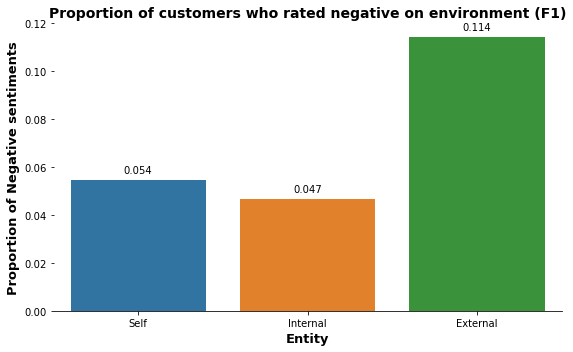

In [70]:
factor_plot('f1',
           title="Proportion of customers who rated negative on environment (F1)")

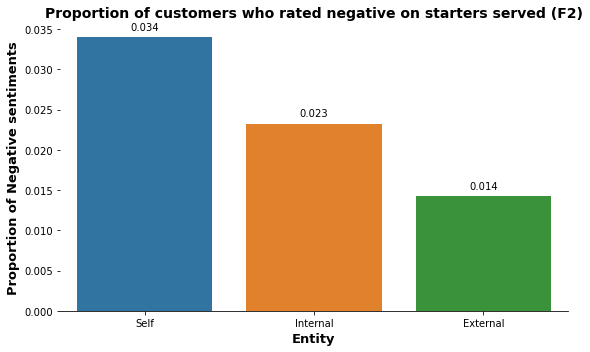

In [71]:
factor_plot('f2',
           title="Proportion of customers who rated negative on starters served (F2)")

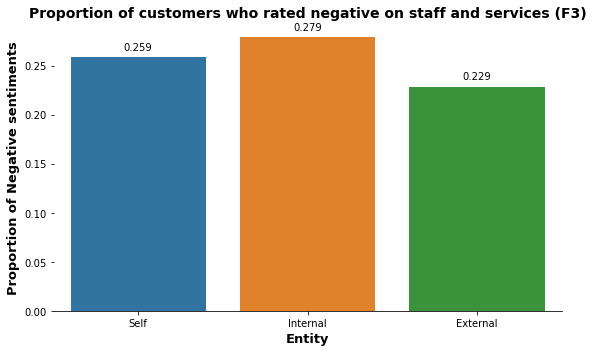

In [72]:
factor_plot('f3',
           title="Proportion of customers who rated negative on staff and services (F3)")

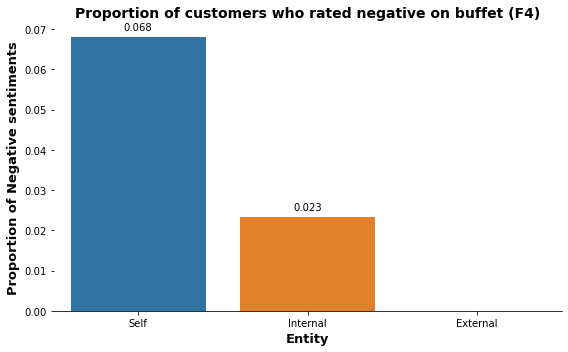

In [73]:
factor_plot('f4',
           title="Proportion of customers who rated negative on buffet (F4)")

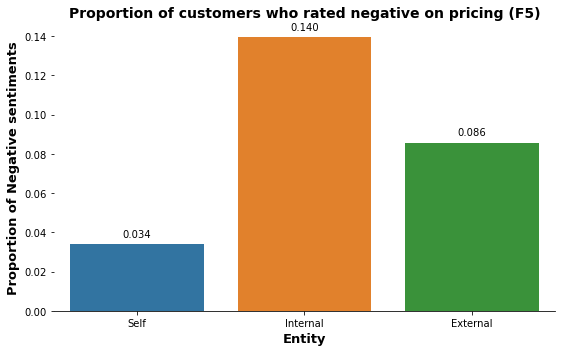

In [74]:
factor_plot('f5',
           title="Proportion of customers who rated negative on pricing (F5)")

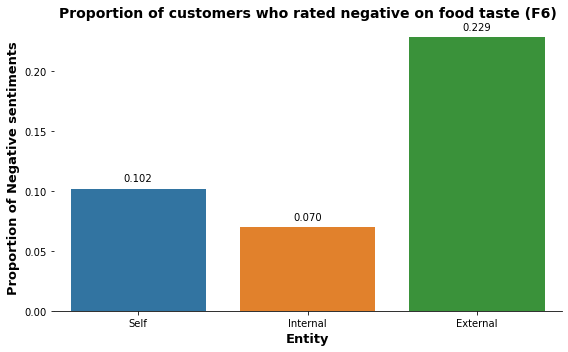

In [75]:
factor_plot('f6',
           title="Proportion of customers who rated negative on food taste (F6)")

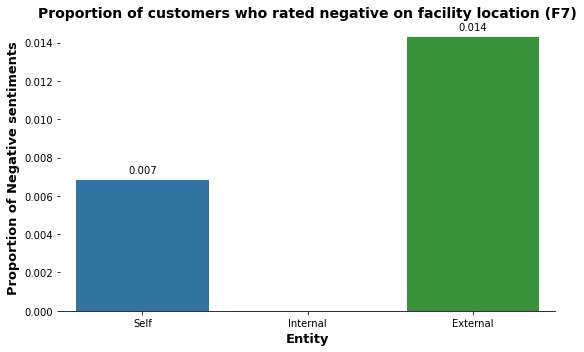

In [76]:
factor_plot('f7',
           title="Proportion of customers who rated negative on facility location (F7)")

In [77]:
df_rca.loc[df_rca['Name']=="China Bistro", ['Name', 'Location', 'City', 'date',
                          'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7',
                          'sentiment_score_sentinet', 'sentiment_score_afinn', 'yes_count', 'lda_topic_id']]

,Name,Location,City,date,f1,f2,f3,f4,f5,f6,f7,sentiment_score_sentinet,sentiment_score_afinn,yes_count,lda_topic_id
91,China Bistro,Worli,Mumbai,8-Nov-19,no,yes,yes,yes,yes,no,no,False,False,4,4
476,China Bistro,Worli,Mumbai,31-Oct-16,no,no,yes,yes,yes,no,no,False,True,3,7
1503,China Bistro,Worli,Mumbai,21-Oct-14,no,no,yes,yes,no,no,no,False,True,2,4
1576,China Bistro,Worli,Mumbai,20-Sep-18,no,yes,yes,yes,yes,no,no,False,True,4,8
1819,China Bistro,Worli,Mumbai,18-Nov-16,no,yes,yes,yes,no,yes,no,False,False,4,4
1852,China Bistro,Worli,Mumbai,18-Jul-16,no,yes,yes,no,yes,no,no,False,True,3,8
2139,China Bistro,Worli,Mumbai,14-Sep-15,no,no,yes,no,no,yes,no,False,False,2,5
2549,China Bistro,Worli,Mumbai,10-May-15,no,yes,no,no,yes,no,no,False,True,2,9


In [78]:
df_sentiwordnet.loc[(df_sentiwordnet['Name']=="China Bistro") & (df_sentiwordnet['sentiment_score_sentinet']==False) & (df_sentiwordnet['yes_count']>1), ['Name', 'Location', 'City', 'date',
                          'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7',
                          'sentiment_score_sentinet', 'sentiment_score_afinn', 'yes_count', 'lda_topic_id']]

,Name,Location,City,date,f1,f2,f3,f4,f5,f6,f7,sentiment_score_sentinet,sentiment_score_afinn,yes_count,lda_topic_id
209,China Bistro,Worli,Mumbai,8-Nov-19,no,no,yes,no,no,no,no,False,False,4,4
231,China Bistro,Worli,Mumbai,31-Oct-16,no,no,no,no,no,no,no,False,True,3,7
275,China Bistro,Worli,Mumbai,21-Oct-14,no,no,no,no,no,no,no,False,True,2,4
277,China Bistro,Worli,Mumbai,20-Sep-18,no,no,no,no,no,no,no,False,True,4,8
287,China Bistro,Worli,Mumbai,18-Nov-16,no,no,yes,no,no,no,no,False,False,4,4
290,China Bistro,Worli,Mumbai,18-Jul-16,no,no,no,no,no,no,no,False,True,3,8
312,China Bistro,Worli,Mumbai,14-Sep-15,no,no,no,no,no,no,no,False,False,2,5
330,China Bistro,Worli,Mumbai,10-May-15,no,no,no,no,yes,no,no,False,True,2,9


In [79]:
df_sentiwordnet.columns

Index(['Name', 'Location', 'City', 'target', 'date', 'review_lemmatized',
       'review_str', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7',
       'sentiment_score_sentinet', 'sentiment_score_afinn', 'yes_count',
       'lda_topic_id', 'Entity'],
      dtype='object')

In [80]:
df_sentiwordnet.date = pd.to_datetime(df_sentiwordnet.date)

In [81]:
df_sentiwordnet['quarter'] = pd.PeriodIndex(df_sentiwordnet.date, freq='Q')

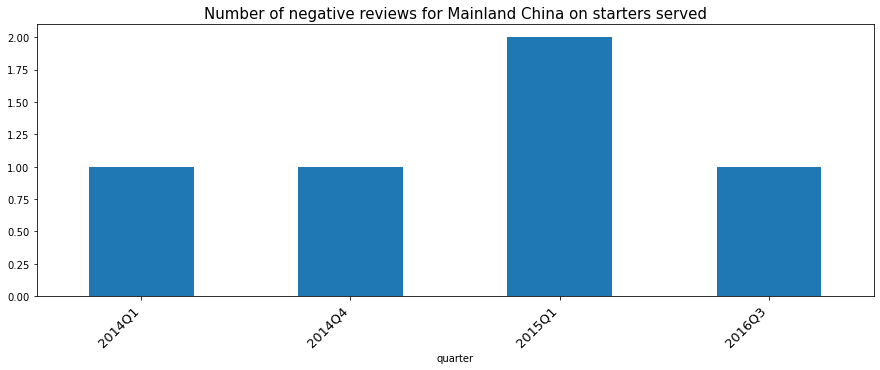

In [82]:
week_groups = df_sentiwordnet.loc[(df_sentiwordnet['f2']=="yes") & (df_sentiwordnet['Entity']=="Self")].groupby(['quarter']
                          )['f2'].count()
week_groups.plot(kind='bar',figsize=(15,5),legend=None);
plt.title('Number of negative reviews for Mainland China on starters served', fontsize=15)
plt.xticks(fontsize=13)
plt.xticks(rotation=45,
        horizontalalignment="right")
plt.show()

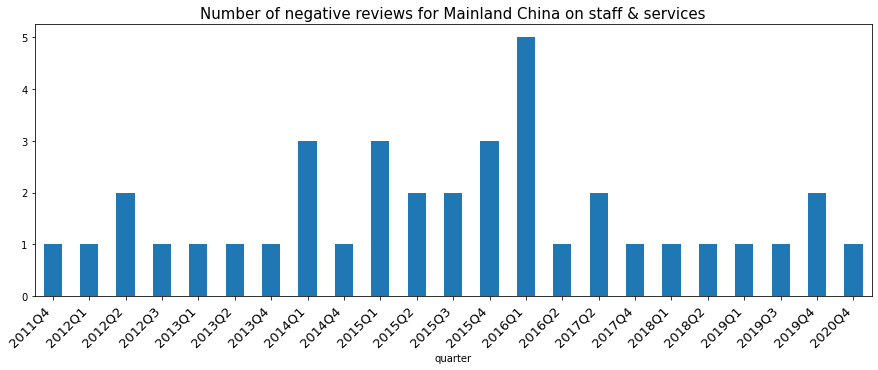

In [83]:
week_groups = df_sentiwordnet.loc[(df_sentiwordnet['f3']=="yes") & (df_sentiwordnet['Entity']=="Self")].groupby(['quarter']
                          )['f3'].count()
week_groups.plot(kind='bar',figsize=(15,5),legend=None);
plt.title('Number of negative reviews for Mainland China on staff & services', fontsize=15)
plt.xticks(fontsize=13)
plt.xticks(rotation=45,
        horizontalalignment="right")
plt.show()

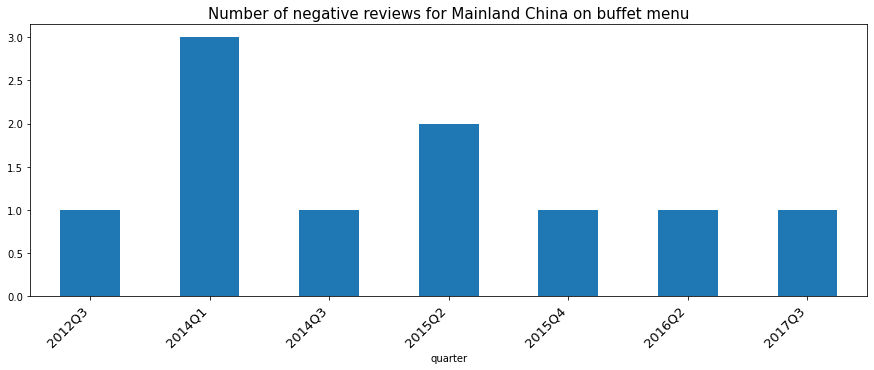

In [84]:
week_groups = df_sentiwordnet.loc[(df_sentiwordnet['f4']=="yes") & (df_sentiwordnet['Entity']=="Self")].groupby(['quarter']
                          )['f4'].count()
week_groups.plot(kind='bar',figsize=(15,5),legend=None);
plt.title('Number of negative reviews for Mainland China on buffet menu', fontsize=15)
plt.xticks(fontsize=13)
plt.xticks(rotation=45,
        horizontalalignment="right")
plt.show()

**Thank You**